# Regime-specific LSTM model
This notebook includes code to investigate LSTM sensitivity to training data by evaluating the performance metrics of multiple LSTM models trained on differing percentages of sites from maritime snowpack regimes. The first section produces plots of model performance metrics and the second section evaluates performance metrics across snowpack regimes for other LSTM models. <br><br> Maritime: WA, OR, CA <br> Intermountain: MT, ID, UT, NV <br> Continental: CO, WY, NM, AZ

In [9]:
## PRELIMINARIES ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random as rn
import pickle
import traceback
import torch
import hf_hydrodata as hf
from tqdm import tqdm
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import joypy
import plotly.express as px
import plotly.graph_objects as go

from _lstm import *
from _data import *

import io
from contextlib import redirect_stdout
trap = io.StringIO()

func_map_year = {'get_years_precip' : get_years_precip, 'get_years_random' : get_years_random}
func_map_site = {'get_sites_full' : get_sites_full, 'get_sites_random' : get_sites_random, 'get_sites_longitude' : get_sites_longitude, 
                 'get_sites_latitude' : get_sites_latitude}

# Plots

In [2]:
## LOAD & COMBINE DATA ##
stats_m30 = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/l6_200_m30_statistics.txt',sep=' ',header=None)
stats_m30.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                                 'delta days','abs delta days']
stats_m40 = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/l6_200_m40_statistics.txt',sep=' ',header=None)
stats_m40.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                                 'delta days','abs delta days']
stats_m50 = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/l6_200_m50_statistics.txt',sep=' ',header=None)
stats_m50.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                                 'delta days','abs delta days']
stats_m60 = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/l6_200_m60_statistics.txt',sep=' ',header=None)
stats_m60.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                                 'delta days','abs delta days']

stats_m30['Percent'] = '30%'
stats_m40['Percent'] = '40%'
stats_m50['Percent'] = '50%'
stats_m60['Percent'] = '60%'

model_statistics = pd.concat([stats_m30, stats_m40, stats_m50, stats_m60], ignore_index=True)

In [3]:
## NORMALIZE ?? ##
# Min-Max Normalization function
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# z score normalization function
def z_score_normalize(column):
    return (column - column.mean()) / column.std()

model_statistics_normalized = model_statistics.drop(['Percent'], axis=1).apply(min_max_normalize)
model_statistics_normalized['Percent'] = model_statistics['Percent']
model_statistics_normalized

,rmse,normal rmse,nse,r2,spearman_rho,delta peak,normal delta peak,abs delta peak,normal abs delta peak,delta days,abs delta days,Percent
0,0.041047,0.164346,0.998464,0.998464,0.847298,0.505653,0.548034,0.031674,0.114206,0.508982,0.154639,30%
1,0.014284,0.083619,0.999648,0.999648,0.864861,0.492028,0.501786,0.004985,0.023567,0.494012,0.128866,30%
2,0.032880,0.094710,0.999478,0.999478,0.929856,0.491856,0.496363,0.004647,0.012938,0.470060,0.087629,30%
3,0.026271,0.193454,0.996973,0.996973,0.757866,0.510574,0.615710,0.041312,0.246843,0.568862,0.257732,30%
4,0.020303,0.123203,0.999153,0.999153,0.900148,0.512766,0.605683,0.045606,0.227192,0.470060,0.087629,30%
...,...,...,...,...,...,...,...,...,...,...,...,...
3611,0.372472,0.459464,0.996822,0.996822,0.834643,0.293961,0.263959,0.382982,0.442539,0.371257,0.082474,60%
3612,0.358085,0.469325,0.996927,0.996927,0.821908,0.294846,0.251419,0.381248,0.467114,0.416168,0.005155,60%
3613,0.186016,0.277023,0.998799,0.998799,0.913147,0.391124,0.349808,0.192659,0.274284,0.410180,0.015464,60%
3614,0.022499,0.262785,0.995888,0.995888,0.110593,0.491426,0.506911,0.003806,0.033611,0.350299,0.118557,60%


In [4]:
## PRINT ACCURACY FOR MODELS ##
print('m_30')
print(f"RMSE: {np.median(stats_m30['rmse']):.2f}")
print(f"normal RMSE: {np.median(stats_m30['normal rmse']):.2f}")
print(f"NSE: {np.median(stats_m30['nse']):.2f}")
print(f"R2: {np.median(stats_m30['r2']):.2f}")
print(f"Spearman's rho: {np.median(stats_m30['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(stats_m30['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(stats_m30['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(stats_m30['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(stats_m30['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(stats_m30['delta days']):.2f}")
print(f"absolute delta days: {np.median(stats_m30['abs delta days']):.2f}")

print('\nm_40')
print(f"RMSE: {np.median(stats_m40['rmse']):.2f}")
print(f"normal RMSE: {np.median(stats_m40['normal rmse']):.2f}")
print(f"NSE: {np.median(stats_m40['nse']):.2f}")
print(f"R2: {np.median(stats_m40['r2']):.2f}")
print(f"Spearman's rho: {np.median(stats_m40['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(stats_m40['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(stats_m40['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(stats_m40['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(stats_m40['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(stats_m40['delta days']):.2f}")
print(f"absolute delta days: {np.median(stats_m40['abs delta days']):.2f}")

print('\nm_50')
print(f"RMSE: {np.median(stats_m50['rmse']):.2f}")
print(f"normal RMSE: {np.median(stats_m50['normal rmse']):.2f}")
print(f"NSE: {np.median(stats_m50['nse']):.2f}")
print(f"R2: {np.median(stats_m50['r2']):.2f}")
print(f"Spearman's rho: {np.median(stats_m50['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(stats_m50['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(stats_m50['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(stats_m50['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(stats_m50['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(stats_m50['delta days']):.2f}")
print(f"absolute delta days: {np.median(stats_m50['abs delta days']):.2f}")

print('\nm_60')
print(f"RMSE: {np.median(stats_m60['rmse']):.2f}")
print(f"normal RMSE: {np.median(stats_m60['normal rmse']):.2f}")
print(f"NSE: {np.median(stats_m60['nse']):.2f}")
print(f"R2: {np.median(stats_m60['r2']):.2f}")
print(f"Spearman's rho: {np.median(stats_m60['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(stats_m60['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(stats_m60['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(stats_m60['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(stats_m60['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(stats_m60['delta days']):.2f}")
print(f"absolute delta days: {np.median(stats_m60['abs delta days']):.2f}")

m_30
RMSE: 60.57
normal RMSE: 0.15
NSE: 0.80
R2: 0.80
Spearman's rho: 0.91
delta peak SWE: 25.99
normal delta peak SWE: 0.06
absolute delta peak SWE: 80.65
absolute normal delta peak SWE: 0.21
delta days: 19.00
absolute delta days: 20.00

m_40
RMSE: 49.92
normal RMSE: 0.13
NSE: 0.85
R2: 0.85
Spearman's rho: 0.91
delta peak SWE: -8.22
normal delta peak SWE: -0.02
absolute delta peak SWE: 66.48
absolute normal delta peak SWE: 0.17
delta days: 16.00
absolute delta days: 17.00

m_50
RMSE: 51.55
normal RMSE: 0.14
NSE: 0.85
R2: 0.85
Spearman's rho: 0.91
delta peak SWE: -10.88
normal delta peak SWE: -0.03
absolute delta peak SWE: 64.94
absolute normal delta peak SWE: 0.18
delta days: 15.00
absolute delta days: 15.00

m_60
RMSE: 58.64
normal RMSE: 0.15
NSE: 0.82
R2: 0.82
Spearman's rho: 0.91
delta peak SWE: 23.65
normal delta peak SWE: 0.07
absolute delta peak SWE: 78.42
absolute normal delta peak SWE: 0.20
delta days: 17.00
absolute delta days: 18.00


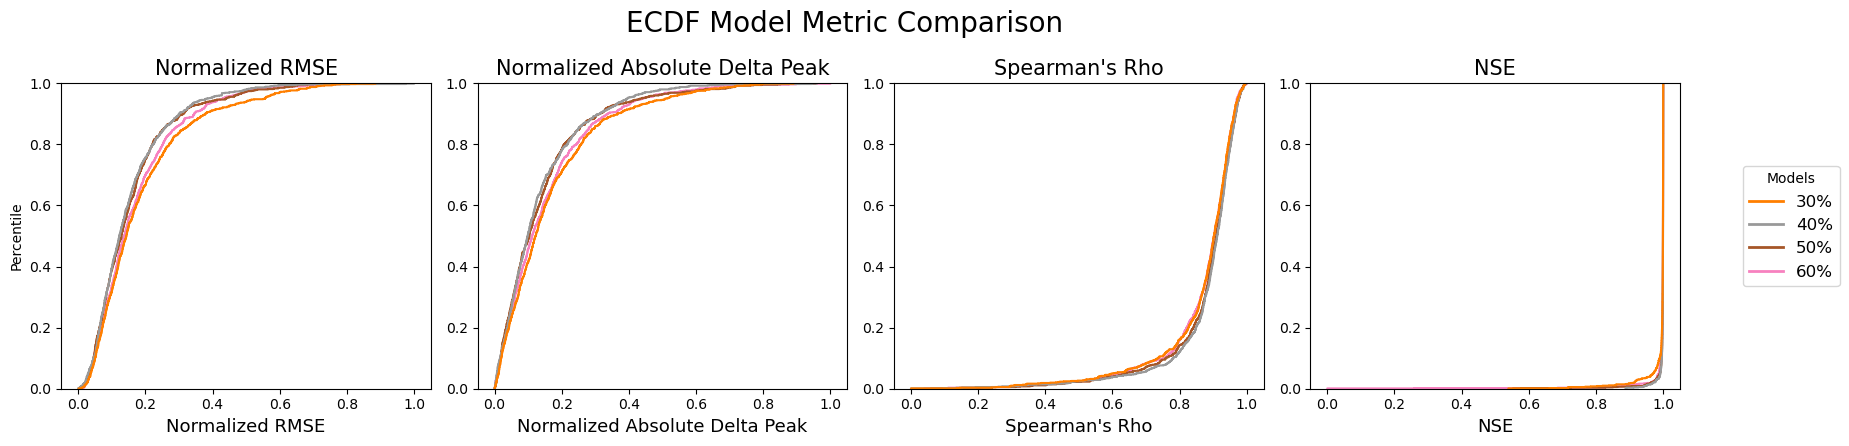

In [9]:
## ECDF FUNCTIONS ##
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 4.5))
custom_palette = ['#FF7F00', '#999999', '#A65628', '#F781BF']

# RMSE
sns.ecdfplot(data=model_statistics_normalized, x='normal rmse', hue='Percent', ax=axes[0], palette=custom_palette, legend=False)
axes[0].set_title('Normalized RMSE', fontsize=15)
axes[0].set_xlabel('Normalized RMSE', fontsize=13)
axes[0].set_ylabel('Percentile')

# Abs Delta Peak
sns.ecdfplot(data=model_statistics_normalized, x='normal abs delta peak', hue='Percent', ax=axes[1], palette=custom_palette, legend=False)
axes[1].set_title('Normalized Absolute Delta Peak', fontsize=15)
axes[1].set_xlabel('Normalized Absolute Delta Peak', fontsize=13)
axes[1].set_ylabel('')

# Spearman rho
sns.ecdfplot(data=model_statistics_normalized, x='spearman_rho', hue='Percent', ax=axes[2], palette=custom_palette, legend=False)
axes[2].set_title('Spearman\'s Rho', fontsize=15)
axes[2].set_xlabel('Spearman\'s Rho', fontsize=13)
axes[2].set_ylabel('')

# NSE
# removed extreme metrics to make it visually make sense - reconsider
sns.ecdfplot(data=model_statistics_normalized, x='nse', hue='Percent', ax=axes[3], palette=custom_palette, legend=False)
axes[3].set_title('NSE', fontsize=15)
axes[3].set_xlabel('NSE', fontsize=13)
axes[3].set_ylabel('')

# plot things
fig.legend([plt.Line2D([0], [0], color=color, lw=2) for color in custom_palette], model_statistics['Percent'].unique(),
           title='Models', loc='center right', bbox_to_anchor=(1.09, 0.5), fontsize=12)
fig.suptitle('ECDF Model Metric Comparison', size=20)
plt.tight_layout()

/home/mcburns/.conda/envs/thesis/lib/python3.9/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,
/home/mcburns/.conda/envs/thesis/lib/python3.9/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,
/home/mcburns/.conda/envs/thesis/lib/python3.9/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,
/home/mcburns/.conda/envs/thesis/lib/python3.9/site-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,


NameError: name 'Line2D' is not defined

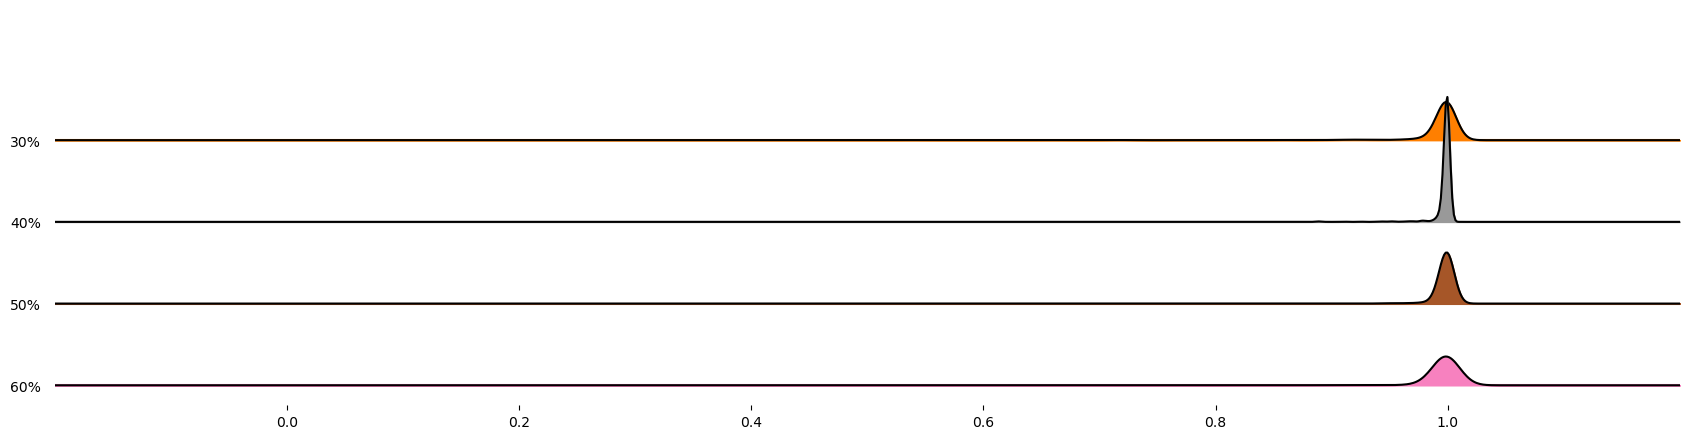

In [12]:
## RIDGE PLOT ##
# not an effective visualization

# Custom palette and unique categories
custom_palette = ['#FF7F00', '#999999', '#A65628', '#F781BF']
unique_latitude_percent = model_statistics_normalized['Percent'].unique()
palette_dict = {k: v for k, v in zip(unique_latitude_percent, custom_palette)}

# List of metrics to plot
metrics = ['rmse', 'abs delta peak', 'spearman_rho', 'nse']
titles = ['Normalized RMSE', 'Normalized Absolute Delta Peak', "Spearman's Rho", 'NSE']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 4.5), sharey=True)

# Loop over each metric and plot
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]

    # Plot each ridge plot on its respective axis
    joypy.joyplot(model_statistics_normalized, by='Percent', column=metric, ax=ax, color=custom_palette)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(title, fontsize=13)
    if i == 0:
        ax.set_ylabel('Percent')
    else:
        ax.set_ylabel('')

# Create a custom legend using Line2D objects
legend_elements = [Line2D([0], [0], color=palette_dict[lat], lw=4, label=lat) for lat in unique_latitude_percent]
fig.legend(handles=legend_elements, title="Percent", loc='center right', bbox_to_anchor=(1.1, 0.5), fontsize=12)

# Global title and layout adjustments
fig.suptitle('Ridge Plot of Model Metric Comparison', size=20)
plt.tight_layout()

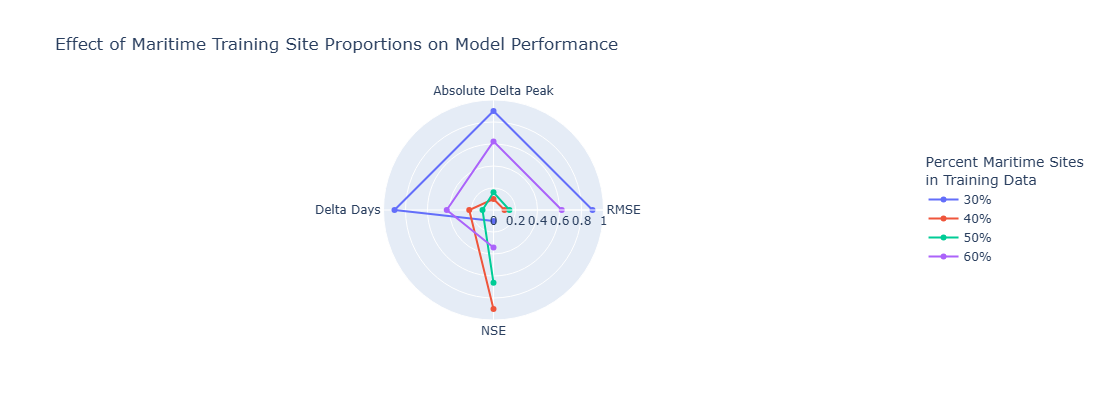

In [6]:
## POLAR PLOT ##
categories = ['RMSE', 'Absolute Delta Peak', 'Delta Days', 'NSE']
data_m30 = [np.mean(stats_m30['rmse']), np.mean(stats_m30['abs delta peak']), np.mean(stats_m30['delta days']), np.mean(stats_m30['nse'])]
data_m40 = [np.mean(stats_m40['rmse']), np.mean(stats_m40['abs delta peak']), np.mean(stats_m40['delta days']), np.mean(stats_m40['nse'])]
data_m50 = [np.mean(stats_m50['rmse']), np.mean(stats_m50['abs delta peak']), np.mean(stats_m50['delta days']), np.mean(stats_m50['nse'])]
data_m60 = [np.mean(stats_m60['rmse']), np.mean(stats_m60['abs delta peak']), np.mean(stats_m60['delta days']), np.mean(stats_m60['nse'])]

# Normalize each metric independently to 0-1 range
scaler = MinMaxScaler(feature_range=(0.1,0.9))
data_scaled = scaler.fit_transform([data_m30, data_m40, data_m50, data_m60])

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=data_scaled[0],theta=categories, name='30%'))
fig.add_trace(go.Scatterpolar(r=data_scaled[1], theta=categories,  name='40%'))
fig.add_trace(go.Scatterpolar(r=data_scaled[2], theta=categories, name='50%'))
fig.add_trace(go.Scatterpolar(r=data_scaled[3], theta=categories,  name='60%'))


fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])), legend_title_text=f"Percent Maritime Sites<br>in Training Data", showlegend=True, 
                  title="Effect of Maritime Training Site Proportions on Model Performance", width=700, height=400, 
                  legend=dict(x=100, y=0.5, xanchor='right', yanchor='middle'))


fig.show()

# Evaluation of model performance across snowpack regimes

In [34]:
## TESTING AND TRAINING DATA ##
run = 'l9_500'

test_data = pd.read_csv('national_test_sites.txt', sep=' ', header=None)
test_data.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']
test_data_years = pd.read_csv('national_test_years.txt', sep=' ', header=None)
test_data_years.columns = ['site_id', 'year','train']
train_data = pd.read_csv('Data/LSTM_output/'+run+'_train_metadata.csv', sep=' ')
train_data['state'] = np.array(x.split(':')[1] for x in train_data['site_id'])

# number of sites in each state
num_maritime_test = len(test_data[test_data.state == 'WA'])+len(test_data[test_data.state == 'OR'])+len(test_data[test_data.state == 'CA'])
num_intermountain_test = len(test_data[test_data.state == 'MT'])+len(test_data[test_data.state == 'UT'])+len(test_data[test_data.state == 'ID'])+len(test_data[test_data.state == 'NV'])
num_continental_test = len(test_data[test_data.state == 'CO'])+len(test_data[test_data.state == 'NM'])+len(test_data[test_data.state == 'AZ'])+len(test_data[test_data.state == 'WY'])

num_maritime_train = len(train_data[train_data.state == 'WA'])+len(train_data[train_data.state == 'OR'])+len(train_data[train_data.state == 'CA'])
num_intermountain_train = len(train_data[train_data.state == 'MT'])+len(train_data[train_data.state == 'UT'])+len(train_data[train_data.state == 'ID'])+len(train_data[train_data.state == 'NV'])
num_continental_train = len(train_data[train_data.state == 'CO'])+len(train_data[train_data.state == 'NM'])+len(train_data[train_data.state == 'AZ'])+len(train_data[train_data.state == 'WY'])

print('Testing data: \n total number of sites: ', len(test_data))
print('total number of years: ', len(test_data_years))
print('maritime percent: ', num_maritime_test/len(test_data))
print('intermountain sites: ', num_intermountain_test/len(test_data))
print('continental sites: ', num_continental_test/len(test_data))

print('\nTraining data for', run, ': \n total number of years: ', len(train_data))
print('number of sites', run, ': \n total number of sites: ', len(np.unique(train_data['site_id'])))
print('maritime percent: ', num_maritime_train/len(train_data))
print('intermountain sites: ', num_intermountain_train/len(train_data))
print('continental sites: ', num_continental_train/len(train_data))

Testing data: 
 total number of sites:  101
total number of years:  904
maritime percent:  0.31683168316831684
intermountain sites:  0.36633663366336633
continental sites:  0.31683168316831684
Training data for l9_500 : 
 total number of years:  4284
number of sites l9_500 : 
 total number of sites:  476
maritime percent:  0.30462184873949577
intermountain sites:  0.3907563025210084
continental sites:  0.3004201680672269
